In [8]:
from Bio.Seq import Seq
from Bio import motifs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import main.functions as fnc
from maxentpy.maxent import load_matrix5, load_matrix3, score5, score3

In [9]:
annotationFile = "./ref/Homo_sapiens.GRCh38.112.chr.gtf.gz"
genomeFile = "./data/Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa.gz"

In [10]:
# use old code to get splice site sequences
transcriptExons = fnc.getExonData(annotationFile)

genome = fnc.openGenomeFile(genomeFile)

fivePrimeSites, threePrimeSites = fnc.getSpliceSites(transcriptExons, genome)

fivePrimeSequences = fnc.extractSequences(fivePrimeSites, genome)
threePrimeSequences = fnc.extractSequences(threePrimeSites, genome)

In [11]:
matrix5 = load_matrix5()
matrix3 = load_matrix3()

spliceSiteStrengths = {"Five Prime Strengths": [], "Three Prime Strengths": []}

# add each strength to the dictionary
for seq5 in fivePrimeSequences:
    if "N" in seq5:
        continue
    spliceSiteStrengths["Five Prime Strengths"].append(score5(seq5, matrix5))

for seq3 in threePrimeSequences:
    if "N" in seq3:
        continue
    spliceSiteStrengths["Three Prime Strengths"].append(score3(seq3, matrix3))

spliceSiteStrengths["Five Prime Strengths"] = np.array(spliceSiteStrengths["Five Prime Strengths"])
spliceSiteStrengths["Three Prime Strengths"] = np.array(spliceSiteStrengths["Three Prime Strengths"])


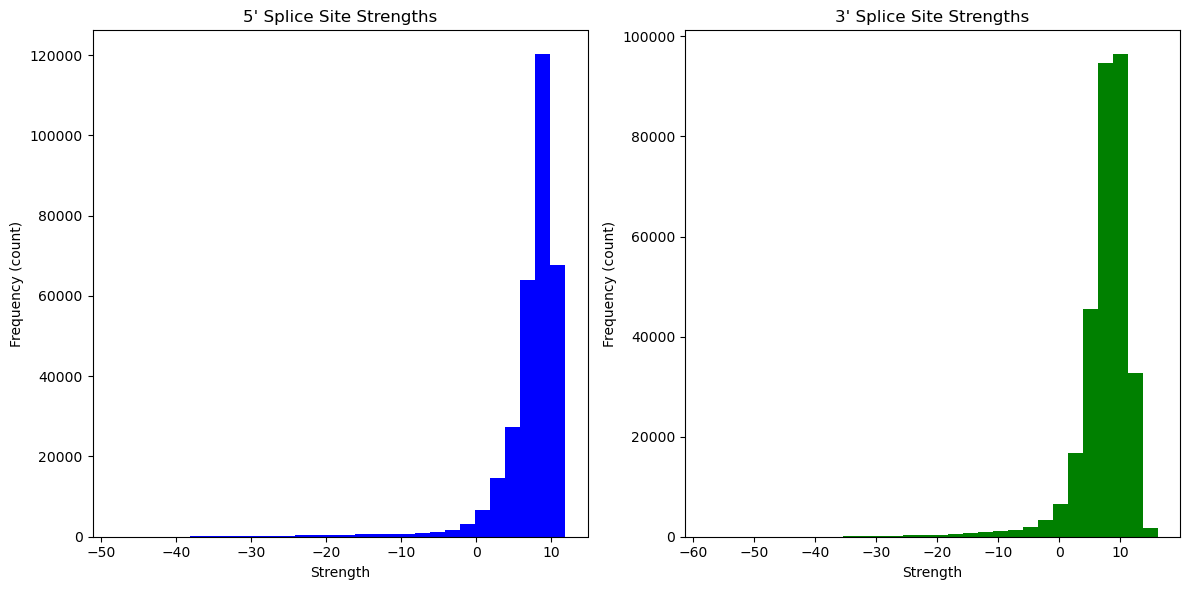

In [12]:
# change to dataframe
# need two seperate DFs because strength arrays are different lengths
FivePrimeDF = pd.DataFrame(spliceSiteStrengths["Five Prime Strengths"], columns = ["Five Prime Strengths"])
ThreePrimeDF = pd.DataFrame(spliceSiteStrengths["Three Prime Strengths"], columns = ["Three Prime Strengths"])

# plot histograms with strength vs. count for 5' and 3' sites
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(FivePrimeDF["Five Prime Strengths"], bins = 30, color='blue')
plt.title('5\' Splice Site Strengths')
plt.xlabel('Strength')
plt.ylabel('Frequency (count)')

plt.subplot(1, 2, 2)
plt.hist(ThreePrimeDF["Three Prime Strengths"], bins = 30, color='green')
plt.title('3\' Splice Site Strengths')
plt.xlabel('Strength')
plt.ylabel('Frequency (count)')

plt.tight_layout()
plt.savefig("./plots/Splice Site Strengths")